In [1]:
import os, sys
my_path = '/content/notebooks'
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

In [2]:
!pip install --target=$my_path jdc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from sklearn.datasets import load_diabetes

In [4]:
dataset = load_diabetes()

In [5]:
feature_names = dataset.feature_names

In [6]:
print(feature_names)

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


In [7]:
X=dataset.data
y=dataset.target
print(X.shape, y.shape)

(442, 10) (442,)


In [8]:
from sklearn.linear_model import LinearRegression
from dslearn import multi_stat

In [9]:
full_model= LinearRegression().fit(X,y)

In [10]:
print("회귀수 \n", multi_stat.lm_stat(model=full_model, X=X, y=y, variables=feature_names))

회귀수 
               coef       se   t_val  Pr(>|t_val|)
Intercept  152.133    2.576  59.061         0.000
age        -10.010   59.749  -0.168         0.867
sex       -239.816   61.222  -3.917         0.000
bmi        519.846   66.533   7.813         0.000
bp         324.385   65.422   4.958         0.000
s1        -792.176  416.680  -1.901         0.058
s2         476.739  339.030   1.406         0.160
s3         101.043  212.531   0.475         0.635
s4         177.063  161.476   1.097         0.273
s5         751.274  171.900   4.370         0.000
s6          67.627   65.984   1.025         0.306


In [14]:
full_r2 = multi_stat.lm_r2(model=full_model,X=X, y=y)
print("수정된 결정계수 :", full_r2)
    

수정된 결정계수 : 0.507


In [16]:
selected_variables = multi_stat.stepwise(X=X, y=y, variables=feature_names[1:])
print("선택된 변수 리스트 \n", selected_variables)

선택된 변수 리스트 
 ['bmi', 's5', 'bp', 's1', 'sex', 's2']


In [17]:
import pandas as pd

In [20]:
X_df = pd.DataFrame(X, columns = feature_names[1:])
sw_X = X_df[selected_variables]
print(sw_X.shape)

(442, 6)


In [26]:
sw_model = LinearRegression().fit(sw_X,y)
print("회귀계수 \n", multi_stat.lm_stat(sw_model, X=sw_X, y=y,variables=selected_variables))

회귀계수 
               coef       se   t_val  Pr(>|t_val|)
Intercept  152.133    2.572  59.159           0.0
bmi        529.880   65.620   8.075           0.0
s5         804.187   80.173  10.031           0.0
bp         327.215   62.693   5.219           0.0
s1        -757.930  160.435  -4.724           0.0
sex       -226.507   59.857  -3.784           0.0
s2         538.580  146.738   3.670           0.0


In [29]:
sw_r2 = multi_stat.lm_r2(sw_model, X=sw_X, y=y, adjust=True)
print("수정된 결정계수 :", sw_r2)

수정된 결정계수 : 0.508


In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
full_pred = full_model.predict(X)
full_mae = mean_absolute_error(y, full_pred)
full_rmse = np.sqrt(mean_squared_error(y, full_pred))

In [35]:
sw_pred = sw_model.predict(sw_X)
sw_mae = mean_absolute_error(y, sw_pred)
sw_rmse = np.sqrt(mean_squared_error(y, sw_pred))

In [37]:
results = pd.DataFrame([[full_r2, full_mae, full_rmse],
                       [sw_r2, sw_mae, sw_rmse]],
                       index=['full model','stepwise model'],
                       columns=['adj_R2', 'MAE','RMSE'])
results.round(2)

,adj_R2,MAE,RMSE
full model,0.51,43.28,53.48
stepwise model,0.51,43.41,53.63


In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1])
pc_X = pca.fit_transform(X)
var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(var_ratio) * 100

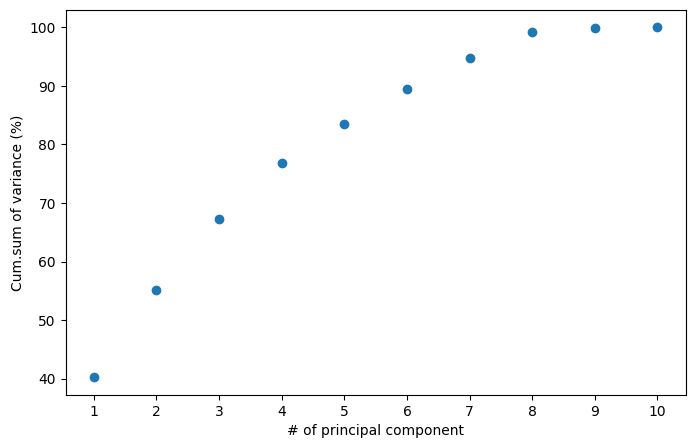

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
xx = [v+1 for v in range(X.shape[1])]
plt.figure(figsize=(8, 5))
plt.scatter(x=xx, y=cum_var)
plt.xticks(xx)
plt.xlabel('# of principal component')
plt.ylabel('Cum.sum of variance (%)')
plt.show()

In [40]:
k = np.where(cum_var >= 70)[0][0]
print("분산의 70%를 유지할 수 있는 주성분의 개수 =", k+1)

분산의 70%를 유지할 수 있는 주성분의 개수 = 4


In [41]:
pc4 = pc_X[:, :k+1]
pc_model = LinearRegression().fit(pc4, y)
pc_var = ['PC'+str(v+1) for v in range(k+1)] # PC1, PC2, PC3, PC4
print("회귀계수 \n", multi_stat.lm_stat(pc_model, X=pc4, y=y, variables=pc_var)) # 생략
pc_r2 = multi_stat.lm_r2(pc_model, X=pc4, y=y, adjust=True)
print("수정된 결정계수 :", pc_r2)


회귀계수 
               coef      se   t_val  Pr(>|t_val|)
Intercept  152.133   2.604  58.424           0.0
PC1        448.195  27.290  16.423           0.0
PC2       -256.749  44.814  -5.729           0.0
PC3        238.241  49.851   4.779           0.0
PC4        593.103  56.006  10.590           0.0
수정된 결정계수 : 0.496


In [42]:
pc_pred = pc_model.predict(pc4)
pc_mae = mean_absolute_error(y, pc_pred) # PCA 기반 회귀모델의 MAE
pc_rmse = np.sqrt(mean_squared_error(y, pc_pred)) # PCA 기반 회귀모델의 RMSE
results.loc[-1] = [pc_r2, pc_mae, pc_rmse]
results.index = ['full model', 'stepwise model', 'PCA model']
print(results.round(2))


                adj_R2    MAE   RMSE
full model        0.51  43.28  53.48
stepwise model    0.51  43.41  53.63
PCA model         0.50  44.31  54.43
